# Preconditioners

## Packages

In [6]:
import torch
import gpytorch
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import os
import gpboost as gpb
import requests
import pandas as pd
import time

In [7]:
# Flag for toy example
toy = True

## Data

In [8]:
# URL of the raw CSV file on GitHub
url = 'https://raw.githubusercontent.com/TimGyger/FSVA/refs/heads/main/Simulation/Data/simulated_data_non_Gaussian_5_prediction.txt'

# Load the CSV file directly from the URL
df = pd.read_csv(url)

# Select the first 5 columns for X
X = df.iloc[:, :5]  # First 5 columns

# Select the last column for y
y = df.iloc[:, 5]  # Last column

# Convert to numpy:
X_np = X.to_numpy()
y_np = y.to_numpy()

if toy:
    X_train = X_np[:5000,:]
    y_train = y_np[:5000]
    X_test = X_np[5000:10000,:]
    y_test = y_np[5000:10000]
else:
    X_train = X_np[:10000,:]
    y_train = y_np[:10000]
    X_test = X_np[10000:200000,:]
    y_test = y_np[10000:200000]

## Predictive Distribution

### Cholesky

In [9]:
model_fsva = gpb.GPModel(gp_coords=X_train, cov_function="gaussian_ard", 
                         likelihood="bernoulli_logit",num_neighbors = 30,num_ind_points = 200,ind_points_selection = "kmeans++",
                         matrix_inversion_method = "cholesky", gp_approx="full_scale_vecchia",seed = 2)

start_time = time.time()
pred_Chol = model_fsva.predict(gp_coords_pred=X_train, y = y_train, 
                               predict_var=True, cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]))
runtime_Chol = time.time() - start_time

[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 


### Iterative

In [10]:
# Different number of sample vectors
vector_sample = [50,100,200,500,1000,2000]
# Number of repetitions
num_rep = 100
if toy:
    num_rep = 10
    vector_sample = [100,200]
# Zero matrices
matrix_SBPV_FITC = np.zeros((len(vector_sample), num_rep))
matrix_SBPV_FITC_t = np.zeros((len(vector_sample), num_rep))
matrix_SBPV_FSVADU = np.zeros((len(vector_sample), num_rep))
matrix_SBPV_FSVADU_t = np.zeros((len(vector_sample), num_rep))
# Nested loop to iterate over both vectors
for i, val1 in enumerate(vector_sample):
    for j in range(0, num_rep):
        print(i)
        print(j)
        
        # FSVecchia with euclidean-based neighbor search
        model_fsva = gpb.GPModel(gp_coords=X_train, cov_function="gaussian_ard", 
                                 likelihood="bernoulli_logit",num_neighbors = 30,num_ind_points = 200,ind_points_selection = "kmeans++",
                                 matrix_inversion_method = "iterative", gp_approx="full_scale_vecchia",seed = 2)
        model_fsva.set_optim_params(params={"cg_preconditioner_type": "predictive_process_plus_diagonal",
                                            "piv_chol_rank": 200, "seed_rand_vec_trace": j+1})
        model_fsva.set_prediction_data(nsim_var_pred = val1)
        # Start the timer
        start_time = time.time()
        pred_it = model_fsva.predict(gp_coords_pred=X_train, y = y_train, 
                               predict_var=True, cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]))
        # End the timer
        end_time = time.time()
        matrix_SBPV_FITC[i, j] = np.sqrt(np.mean(np.square(pred_Chol['var'] - pred_it['var'])))
        # Calculate elapsed time in seconds
        matrix_SBPV_FITC_t[i, j] = end_time - start_time
        
        # FSVecchia with euclidean-based neighbor search
        model_fsva = gpb.GPModel(gp_coords=X_train, cov_function="gaussian_ard", 
                                 likelihood="bernoulli_logit",num_neighbors = 30,num_ind_points = 200,ind_points_selection = "kmeans++",
                                 matrix_inversion_method = "iterative", gp_approx="full_scale_vecchia",seed = 2)
        model_fsva.set_optim_params(params={"cg_preconditioner_type": "Bt_Sigma_inv_plus_W_B",
                                            "piv_chol_rank": 200, "seed_rand_vec_trace": j+1})
        model_fsva.set_prediction_data(nsim_var_pred = val1)
        # Start the timer
        start_time = time.time()
        pred_it = model_fsva.predict(gp_coords_pred=X_train, y = y_train, 
                               predict_var=True, cov_pars = np.array([1.0, 0.15, 0.30,0.45,0.60,0.75]))
        # End the timer
        end_time = time.time()
        matrix_SBPV_FSVADU[i, j] = np.sqrt(np.mean(np.square(pred_Chol['var'] - pred_it['var'])))
        # Calculate elapsed time in seconds
        matrix_SBPV_FSVADU_t[i, j] = end_time - start_time
        
        

0
0
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
0
1
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
0
2
[GPBoost] [Info] Starting kmeans++ algorithm for determining inducing points 
[GPBoost] [Info] Inducing points have been determined 
[GPBoost] [Info] Starting kmeans++ algorithm for determin

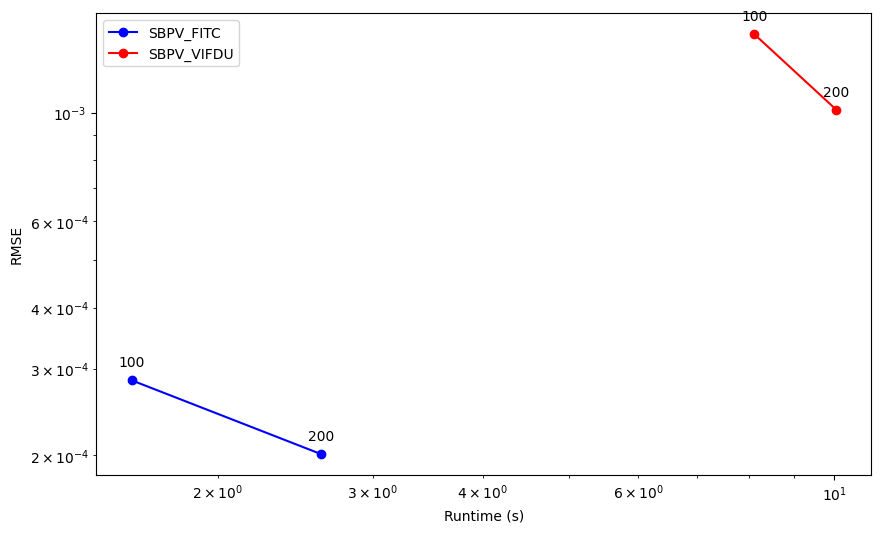

In [14]:
# Plotting the data
fig, ax = plt.subplots(figsize=(10, 6))

# Function to plot lines with points and annotations
def plot_matrix_data(matrix_data, matrix_time, label, color):
    mean_vals = np.nanmean(matrix_data, axis=1)
    mean_times = np.mean(matrix_time, axis=1)
    ax.plot(mean_times, mean_vals, label=label, color=color, marker='o')

    # Annotate the points with the vector_sample values
    for i, (x, y) in enumerate(zip(mean_times, mean_vals)):
        ax.annotate(f'{vector_sample[i]}', (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

# Plot for SBPV_FITC
plot_matrix_data(matrix_SBPV_FITC, matrix_SBPV_FITC_t, 'SBPV_FITC', 'b')

# Plot for SPV_FITC
plot_matrix_data(matrix_SBPV_FSVADU, matrix_SBPV_FSVADU_t, 'SBPV_VIFDU', 'r')


# Set plot properties
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Runtime (s)')
ax.set_ylabel('RMSE')
ax.legend()

# Show plot
plt.show()